**Installation:**
Import the necessary modules for probing. It is assumed that this notebook runs in a clone of our repository.

In [1]:
from edge_probing_utils import (
    JiantDatasetSingleSpan,
    JiantDatasetTwoSpan
    )
import edge_probing as ep
import torch
import torch.nn as nn
import torch.utils.data as data
from transformers import AutoModel, AutoTokenizer


**Setup:**
Select the tasks and models to run and pick a dataset size. Since the time for a probing tasks depends on the patience, patience_lr and max_evals parameters in the ProbeConfig, it is adviced to always select the big dataset.

The model finetuned on the adversarialQA dataset has to be manually downloaded from Google Drive linked in the README linked in the READMEand the path adjusted in the models list and the dictionaries.

In [2]:
tasks = [
    #"ner", 
    #"semeval",
    "coref",
    #"sup-squad",
    #"ques",
    #"sup-babi",
    "adversarialqa",
    ]

task_types = {
    "ner": "single_span", 
    "semeval": "single_span",
    "coref": "two_span",
    "sup-squad": "two_span",
    "ques": "single_span",
    "sup-babi": "two_span",
    "adversarialqa": "two_span",
    }

models = [
    "roberta-base",
    #"bert-base-uncased", 
    #"csarron/bert-base-uncased-squad-v1",
    #"../../models/BERT_adversarialqa",
    ]

task_labels_to_ids = {
    "ner": {'ORDINAL': 0, 'DATE': 1, 'PERSON': 2, 'LOC': 3, 'GPE': 4, 'QUANTITY': 5, 'ORG': 6, 'WORK_OF_ART': 7, 'CARDINAL': 8, 'TIME': 9, 'MONEY': 10, 'LANGUAGE': 11, 'NORP': 12, 'PERCENT': 13, 'EVENT': 14, 'LAW': 15, 'FAC': 16, 'PRODUCT': 17},
    "coref": {"0": 0, "1": 1},
    "semeval": {'Component-Whole(e2,e1)': 0, 'Other': 1, 'Instrument-Agency(e2,e1)': 2, 'Member-Collection(e1,e2)': 3, 'Entity-Destination(e1,e2)': 4, 'Content-Container(e1,e2)': 5, 'Message-Topic(e1,e2)': 6, 'Cause-Effect(e2,e1)': 7, 'Product-Producer(e2,e1)': 8, 'Member-Collection(e2,e1)': 9, 'Entity-Origin(e1,e2)': 10, 'Cause-Effect(e1,e2)': 11, 'Component-Whole(e1,e2)': 12, 'Message-Topic(e2,e1)': 13, 'Product-Producer(e1,e2)': 14, 'Entity-Origin(e2,e1)': 15, 'Content-Container(e2,e1)': 16, 'Instrument-Agency(e1,e2)': 17, 'Entity-Destination(e2,e1)': 18},
    "sup-squad": {"0": 0, "1": 1},
    "ques": {'LOC:other': 0, 'DESC:desc': 1, 'DESC:def': 2, 'DESC:manner': 3, 'ENTY:sport': 4, 'ENTY:termeq': 5, 'HUM:ind': 6, 'NUM:count': 7, 'DESC:reason': 8, 'LOC:country': 9, 'HUM:desc': 10, 'ENTY:animal': 11, 'ENTY:other': 12, 'LOC:city': 13, 'ENTY:cremat': 14, 'NUM:perc': 15, 'NUM:money': 16, 'NUM:date': 17, 'ENTY:dismed': 18, 'LOC:state': 19, 'NUM:speed': 20, 'HUM:gr': 21, 'NUM:dist': 22, 'ENTY:food': 23, 'ABBR:abb': 24, 'ENTY:product': 25, 'HUM:title': 26, 'NUM:weight': 27, 'ABBR:exp': 28, 'ENTY:veh': 29, 'NUM:period': 30, 'ENTY:religion': 31, 'ENTY:letter': 32, 'ENTY:color': 33, 'ENTY:body': 34, 'ENTY:event': 35, 'ENTY:substance': 36, 'ENTY:instru': 37, 'ENTY:plant': 38, 'ENTY:symbol': 39, 'NUM:other': 40, 'LOC:mount': 41, 'NUM:temp': 42, 'ENTY:techmeth': 43, 'NUM:code': 44, 'ENTY:word': 45, 'ENTY:lang': 46, 'NUM:volsize': 47, 'NUM:ord': 48, 'ENTY:currency': 49},
    "sup-babi": {"0": 0, "1": 1},
    "adversarialqa": {"0": 0, "1": 1},
    }

# Pick a dataset size: small, medium, big.
# With the way training works, a smaller size will only improve the speed of tokenizing,
# training speed will be the same for all sizes.
size = "medium"

**Run:**
Run the selected probing tasks. Select the layers to probe and the device. If another device than the TPU is used make sure to comment out the first two imports (torch_xla and torch_xla.core.xla_model) and set tpu to False. Furthermore the import edge_probing_tpu two cells above needs to be commented out.

The results of the run are saved to ../results/{size}.json. This file is updated everytime a task was probed on all selected layers. If for some reason the notebook fails to probe all layers, the intermediate results of the last task can be found at the specified results_path (by default ../intermediate-results/results.jso).

In [ ]:
import os
import json
import matplotlib.pyplot as plt

loss_function = nn.BCELoss()
batch_size = 32
num_layers = range(1,2,2)
num_workers = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

# Disable warnings.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

os.makedirs(f"../results/", exist_ok=True)
os.makedirs(f"../intermediate-results/", exist_ok=True)


for model in models:
    tokenizer = AutoTokenizer.from_pretrained(model)
    for task in tasks:
        if os.path.isfile(f'../results/{size}.json'):
            with open(f'../results/{size}.json', 'r') as f:
                results = json.load(f)
        else:
            results = {}
        task_results = results.setdefault(task, {})
        labels_to_ids = task_labels_to_ids[task]
        train_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"../data/{task}/{size}/train.jsonl")),
            labels_to_ids,
            max_seq_length=384
            )
        val_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"../data/{task}/{size}/val.jsonl")),
            labels_to_ids,
            max_seq_length=384
            )
        test_data = ep.tokenize_jiant_dataset(
            tokenizer,
            *(ep.read_jiant_dataset(f"../data/{task}/{size}/test.jsonl")),
            labels_to_ids,
            )
        if task_types[task] == "single_span":
            train_data = JiantDatasetSingleSpan(train_data)
            val_data = JiantDatasetSingleSpan(val_data)
            test_data = JiantDatasetSingleSpan(test_data)
        elif task_types[task] == "two_span":
            train_data = JiantDatasetTwoSpan(train_data)
            val_data = JiantDatasetTwoSpan(val_data)
            test_data = JiantDatasetTwoSpan(test_data)
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
        val_loader = data.DataLoader(val_data, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
        test_loader = data.DataLoader(test_data, batch_size=batch_size, pin_memory=True, num_workers=num_workers)
        results[task][model] = ep.probing(ep.ProbeConfig(
                train_loader,
                val_loader,
                test_loader,
                model,
                num_layers,
                loss_function,
                labels_to_ids,
                task_types[task],
                lr=0.0001,
                patience=5,
                eval_interval=1000,
                dev=device,
                results_path=f"../intermediate-results/",
                ))
        with open(f'../results/{size}.json', 'w') as f:
            json.dump(results, f)

**Visualize the results:**

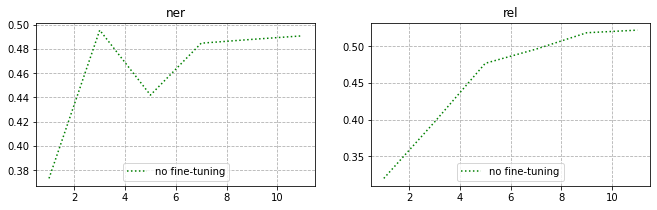

In [11]:
import json
import matplotlib.pyplot as plt
import edge_probing as ep


models = [
    "roberta-base",
    "bert-base-uncased", 
    "csarron/bert-base-uncased-squad-v1",
    "/content/drive/MyDrive/BERT_fineTunned_on_AdversarialQA_trained",
    ]
tasks = [
    #"ner", 
    #"semeval",
    "coref",
    #"sup-squad",
    #"ques",
    #"sup-babi",
    ]

model_to_label = {
    "roberta-base": "RoBERTa",
    "bert-base-uncased": "no fine-tuning", 
    "csarron/bert-base-uncased-squad-v1": "SQuAD",
    "/content/drive/MyDrive/BERT_fineTunned_on_AdversarialQA_trained": "adversarialQA",
    }
model_to_linestyle = {
    "bert-base-uncased": ":g", 
    "csarron/bert-base-uncased-squad-v1": "-y",
    "/content/drive/MyDrive/BERT_fineTunned_on_AdversarialQA_trained": "--b",
    "roberta-base": "-.r",
    }
task_to_title = {
    "coref": "COREF",
    "ques": "Question Type",
    "sup-squad": "Supporting Facts SQuAD",
    "sup-babi": "Supporting Facts bAbI",
    "ner": "Named Entity Labeling",
    "semeval": "Relation Classification",
    "adversarialqa": "Adversarial QA"
    }

size = "big"
num_layers = range(1,13,2)

f, axs = plt.subplots(1, len(tasks), figsize=(len(tasks)*5 + 1, 3))
i = 0

for task in tasks:
    for model in models:
        ep.plot_task(
            f"./results/{size}.json",
            task,
            model,
            model_to_linestyle[model],
            num_layers,
            label=model_to_label[model],
            title=task_to_title[task],
            plot=axs[i]
            )
    i += 1
plt.show()